In [217]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import h3
from geopy.distance import geodesic

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

from matplotlib.ticker import MultipleLocator

## ToDo-Liste

- [ ] Verhältnis total miles und total price
  - [ ] Ausreißer rausschmeißen? Randfälle sind bei 100 000 schon 15 000
  - [ ] Möglichkeit Distanz und Zeit künstlich hinzufügen durch (Durchschnitt, Distanzberechnung) evaluieren
- [ ] Weitere Features hinzufügen
  - [ ] Distance to city centre
  - [ ] Fahrt zum Sportevent oder Fahrt zum Cafe
  - [ ] Distance to next café, POI point
- [ ] Welche spatial Information? Census-Tract Koordinaten, Community Area Daten, Centroid Daten und H3 mit Res 4, 6, 8
  - [ ] Census-Tract Koordinaten
  - [ ] Community Area Daten
  - [ ] Centroid Daten
  - [ ] H3 mit Res 4, 6, 8

## Data Loading, Checking, further Data Preparation and Cleaning

In [218]:
data = pd.read_csv("../data/analytics_trip_data.csv")

In [219]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
# Korrekte Verwendung der describe-Methode
data.describe()

# Überprüfe auf NaN-Werte jeder Spalte
nan_info = data.isna().sum()
print(nan_info)

trip_id                          0
taxi_id                          9
trip_start_timestamp             0
trip_end_timestamp               0
trip_seconds                    22
trip_miles                      12
pickup_census_tract          53342
dropoff_census_tract         53342
pickup_community_area           53
dropoff_community_area         830
fare                            19
tips                            19
tolls                        41959
extras                          19
trip_total                      19
payment_type                     0
company                          0
pickup_centroid_location         0
dropoff_centroid_location        0
h3_res_4_pickup                  0
h3_res_4_dropoff                 0
h3_res_6_pickup                  0
h3_res_6_dropoff                 0
h3_res_8_pickup                  0
h3_res_8_dropoff                 0
date                             0
temperature                      0
precipitation                    0
Game_End            

In [220]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217461 entries, 0 to 217460
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   trip_id                    217461 non-null  object 
 1   taxi_id                    217452 non-null  object 
 2   trip_start_timestamp       217461 non-null  object 
 3   trip_end_timestamp         217461 non-null  object 
 4   trip_seconds               217439 non-null  float64
 5   trip_miles                 217449 non-null  float64
 6   pickup_census_tract        164119 non-null  float64
 7   dropoff_census_tract       164119 non-null  float64
 8   pickup_community_area      217408 non-null  float64
 9   dropoff_community_area     216631 non-null  float64
 10  fare                       217442 non-null  float64
 11  tips                       217442 non-null  float64
 12  tolls                      175502 non-null  float64
 13  extras                     21

In [221]:
data.head(1)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_location,dropoff_centroid_location,h3_res_4_pickup,h3_res_4_dropoff,h3_res_6_pickup,h3_res_6_dropoff,h3_res_8_pickup,h3_res_8_dropoff,date,temperature,precipitation,Game_End,sports_event,poi_h3_res_8,poi_h3_res_6,poi_h3_res_4
0,431a17aafe54877bf8effca97998bc93c0a804de,e58217aab55360fd47c24c931ec25c7ab0cf7bd3917c8b98b9b1f851051a0b065f0cd8380970f70bf1b09d5453b4b2d42f81b990ac3687940ccb5a4e2fe0a216,2018-01-01 00:15:00,2018-01-01 00:30:00,945.0,3.6,1.703124e+10,1.703108e+10,24.0,8.0,13.5,2.8,0.0,0.0,16.8,Credit Card,Taxi Affiliation Service Yellow,POINT (-87.6753116216 41.906025969),POINT (-87.6288741572 41.8920726347),842664dffffffff,842664dffffffff,862664cafffffff,862664c1fffffff,882664cac1fffff,882664c1e1fffff,2018-01-01 01:53:00,-18.333333,0.0,2018-01-01 00:00:00,0.0,66.0,563.0,3458


In [222]:
#Hier erstmal date genommen, vielleicht doch lieber startzeit?
data['date_column'] = pd.to_datetime(data['date'])
data['hour']= data["date_column"].dt.hour
data['weekday']=data["date_column"].dt.weekday
data["month"]=data["date_column"].dt.month

data = data[(data['trip_seconds'] != 0) & (data['trip_miles'] != 0) & (data['fare'] != 0)]

data['price_per_mile'] = data['trip_total'] / data['trip_miles']

In [223]:
average_price_per_mile_per_company = data.groupby('company')['price_per_mile'].mean().sort_values()
pd.set_option('display.max_rows', len(average_price_per_mile_per_company))
average_price_per_mile_per_company

company
2809 - 95474 C & D Cab Co Inc.                   3.214286
3556 - 36214 RC Andrews Cab                      3.858660
3669 - 85800 Jordan Taxi Inc                     4.434145
303 Taxi                                         4.771226
5074 - 54002 Ahzmi Inc                           4.838539
4053 - 40193 Adwar H. Nikola                     5.187244
5997 - 65283 AW Services Inc.                    5.357797
3721 - Santamaria Express, Alvaro Santamaria     5.385289
Norshore Cab                                     6.098280
2241 - 44667 - Felman Corp, Manuel Alonso        6.140990
2092 - 61288 Sbeih company                       6.142685
5874 - 73628 Sergey Cab Corp.                    6.145306
American United Taxi Affiliation                 6.265718
Leonard Cab Co                                   6.377187
0118 - 42111 Godfrey S.Awir                      6.389594
0694 - 59280 Chinesco Trans Inc                  6.407563
3591 - 63480 Chuks Cab                           6.464822
Metro 

Vor dem Entfernen der Ausreißer:
count    191184.000000
mean         10.773280
std         127.739126
min           0.000244
25%           4.043529
50%           6.041667
75%           8.695652
max       43563.400000
Name: price_per_mile, dtype: float64
4.043528974237609
8.695652173913045


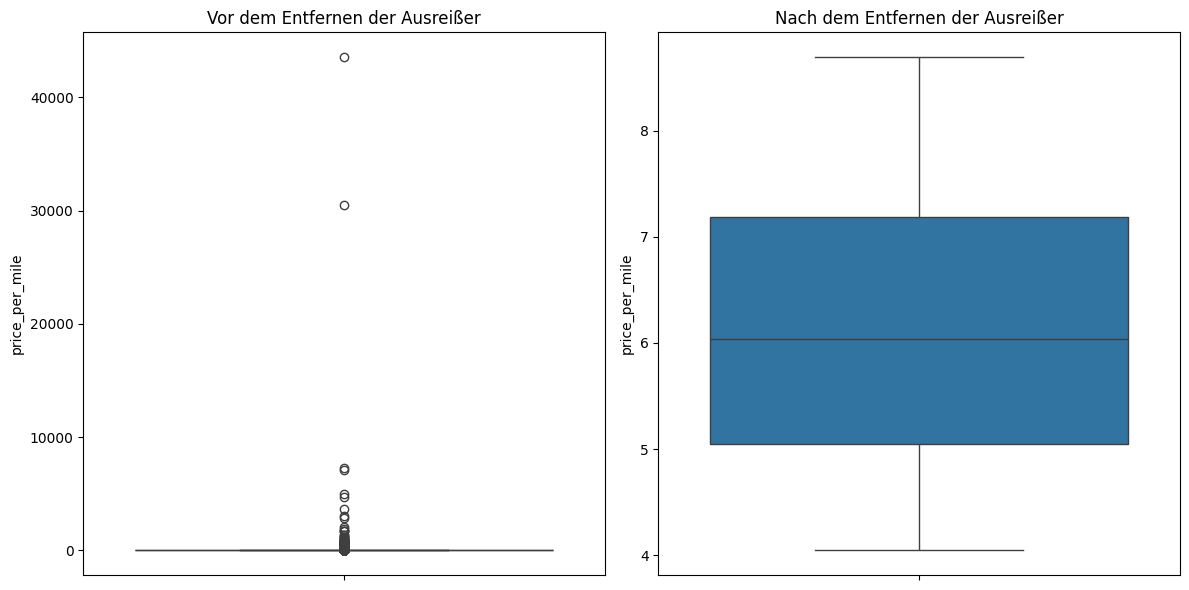


Nach dem Entfernen der Ausreißer:
count    95625.000000
mean         6.146232
std          1.278882
min          4.043546
25%          5.050000
50%          6.041667
75%          7.187500
max          8.695652
Name: price_per_mile, dtype: float64


In [224]:
print("Vor dem Entfernen der Ausreißer:")
print(data['price_per_mile'].describe())


# Visualisierung vor dem Entfernen der Ausreißer
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data['price_per_mile'])
plt.title('Vor dem Entfernen der Ausreißer')

# Identifizierung der Ausreißer mit der IQR-Methode
Q1 = data['price_per_mile'].quantile(0.25)
Q3 = data['price_per_mile'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 0.0 * IQR
upper_bound = Q3 + 0.0 * IQR

print(lower_bound)
print(upper_bound)

# Entfernen der Ausreißer
data = data[(data['price_per_mile'] >= lower_bound) & (data['price_per_mile'] <= upper_bound)]

# Visualisierung nach dem Entfernen der Ausreißer
plt.subplot(1, 2, 2)
sns.boxplot(data['price_per_mile'])
plt.title('Nach dem Entfernen der Ausreißer')
plt.tight_layout()
plt.show()

print("\nNach dem Entfernen der Ausreißer:")
print(data['price_per_mile'].describe())

In [225]:
average_price_per_mile_per_company = data.groupby('company')['price_per_mile'].mean().sort_values()
average_price_per_mile_per_company

company
3669 - 85800 Jordan Taxi Inc                    4.096552
5062 - 34841 Sam Mestas                         5.418525
Norshore Cab                                    5.469770
3721 - Santamaria Express, Alvaro Santamaria    5.506055
3591 - 63480 Chuks Cab                          5.814416
3556 - 36214 RC Andrews Cab                     5.817917
4053 - 40193 Adwar H. Nikola                    5.859101
American United Taxi Affiliation                5.863928
Dispatch Taxi Affiliation                       5.914943
3623 - 72222 Arrington Enterprises              5.958222
5997 - 65283 AW Services Inc.                   5.964461
4615 - 83503 Tyrone Henderson                   6.015467
Checker Taxi                                    6.021692
312 Medallion Management Corp                   6.031415
Setare Inc                                      6.047075
6743 - 78771 Luhak Corp                         6.053582
Flash Cab                                       6.060367
1469 - 64126 Omar Jada 

In [226]:
# Koordinaten des Stadtzentrums von Chicago
#chicago_coords = (41.8781, -87.6298)
#chicago_h3 = h3.geo_to_h3(chicago_coords[0], chicago_coords[1], 8)
#data['distance_to_chicago'] = data['h3_res_8'].apply(lambda h3_index: h3.h3_distance(chicago_h3, h3_index))

In [227]:
# Koordinaten des Stadtzentrums von Chicago
chicago_coords = (41.8781, -87.6298)

# Funktion zum Extrahieren der Koordinaten aus dem WKT-Format
def extract_coords(point):
    point = point.replace('POINT (', '').replace(')', '')
    lon, lat = map(float, point.split())
    return lat, lon

# Funktion zur Berechnung der Distanz
def calculate_distance_to_chicago(point):
    point_coords = extract_coords(point)
    return geodesic(point_coords, chicago_coords).miles

# Berechnen der Distanz zu Chicago und Hinzufügen einer neuen Spalte
data['distance_to_chicago'] = data['pickup_centroid_location'].apply(calculate_distance_to_chicago)

# Berechnen der Distanz zu Chicago und Hinzufügen einer neuen Spalte
data['distance_from_chicago'] = data['dropoff_centroid_location'].apply(calculate_distance_to_chicago)


## Feature Creating & Selection

In [228]:
features = ["trip_seconds", "price_per_mile", "trip_miles", "fare", "hour", "weekday", "month","temperature", "distance_to_chicago", "distance_from_chicago"]

In [229]:
Cluster_all = data[features]

In [230]:
Cluster_all.describe()

,trip_seconds,price_per_mile,trip_miles,fare,hour,weekday,month,temperature,distance_to_chicago,distance_from_chicago
count,95616.000000,95625.000000,95625.000000,95625.000000,95625.000000,95625.000000,95625.000000,95625.000000,95625.000000,95625.000000
mean,629.481813,6.146232,1.805625,8.682509,13.665370,2.831278,6.316361,12.085072,1.646687,1.832228
std,764.296729,1.278882,1.223403,3.796476,5.488796,1.864249,3.348362,11.842787,2.283742,2.186624
min,1.000000,4.043546,0.300000,0.010000,0.000000,0.000000,1.000000,-22.777778,0.243471,0.243471
25%,395.000000,5.050000,1.100000,6.500000,10.000000,1.000000,3.000000,2.222222,0.657472,0.667513
50%,540.000000,6.041667,1.500000,8.000000,14.000000,3.000000,6.000000,10.555556,1.011416,1.279285
75%,737.000000,7.187500,2.110000,9.750000,18.000000,4.000000,9.000000,22.777778,1.494985,1.916529
max,79685.000000,8.695652,31.900000,134.500000,23.000000,6.000000,12.000000,35.555556,16.238510,16.551312


In [231]:
# Bestimmte Spalten auswählen
columns_of_interest = ['trip_seconds', 'trip_miles', 'fare']

# Anzahl der Nullwerte in den ausgewählten Spalten
zero_counts_selected_columns = (Cluster_all[columns_of_interest] == 0).sum()
print("Anzahl der Nullwerte (0 oder 0.000) in den ausgewählten Spalten:")
print(zero_counts_selected_columns)

# Gesamtzahl der Nullwerte in den ausgewählten Spalten
total_zeros_selected_columns = (Cluster_all[columns_of_interest] == 0).sum().sum()
print("\nGesamtzahl der Nullwerte (0 oder 0.000) in den ausgewählten Spalten:")
print(total_zeros_selected_columns)

Anzahl der Nullwerte (0 oder 0.000) in den ausgewählten Spalten:
trip_seconds    0
trip_miles      0
fare            0
dtype: int64

Gesamtzahl der Nullwerte (0 oder 0.000) in den ausgewählten Spalten:
0


In [232]:
Cluster_all.info()
print(len(Cluster_all))
print(Cluster_all['price_per_mile'].isna().sum())
Cluster_all.dropna(inplace=True)
print(len(Cluster_all))
Cluster_all.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 95625 entries, 0 to 217460
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trip_seconds           95616 non-null  float64
 1   price_per_mile         95625 non-null  float64
 2   trip_miles             95625 non-null  float64
 3   fare                   95625 non-null  float64
 4   hour                   95625 non-null  int32  
 5   weekday                95625 non-null  int32  
 6   month                  95625 non-null  int32  
 7   temperature            95625 non-null  float64
 8   distance_to_chicago    95625 non-null  float64
 9   distance_from_chicago  95625 non-null  float64
dtypes: float64(7), int32(3)
memory usage: 6.9 MB
95625
0
95616


C:\Users\kevin\AppData\Local\Temp\ipykernel_15168\8445324.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cluster_all.dropna(inplace=True)


,trip_seconds,price_per_mile,trip_miles,fare,hour,weekday,month,temperature,distance_to_chicago,distance_from_chicago
count,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000
mean,629.481813,6.146274,1.805324,8.681195,13.665600,2.831137,6.316192,12.084641,1.646611,1.832074
std,764.296729,1.278907,1.219936,3.774768,5.488344,1.864195,3.348377,11.843033,2.283651,2.186074
min,1.000000,4.043546,0.300000,0.010000,0.000000,0.000000,1.000000,-22.777778,0.243471,0.243471
25%,395.000000,5.050000,1.100000,6.500000,10.000000,1.000000,3.000000,2.222222,0.657472,0.667513
50%,540.000000,6.041667,1.500000,8.000000,14.000000,3.000000,6.000000,10.555556,1.011416,1.279285
75%,737.000000,7.187500,2.110000,9.750000,18.000000,4.000000,9.000000,22.777778,1.494985,1.916529
max,79685.000000,8.695652,31.900000,115.000000,23.000000,6.000000,12.000000,35.555556,16.238510,16.551312


In [233]:
#Cluster_all_ohe = pd.get_dummies(Cluster_all, columns=["hour", "weekday", "month"])
def one_hot_encoding(df, list):
    for element in list:
        one_hot_encoded = pd.get_dummies(df[element], prefix=element)

        one_hot_encoded = one_hot_encoded.astype(int)
        
        # Concatenate the one-hot encoded features with the original DataFrame
        df = pd.concat([df, one_hot_encoded], axis=1)

        # Drop the original column after one-hot encoding
        df = df.drop(columns=[element])
    return  df

Cluster_all_ohe = one_hot_encoding(Cluster_all, ["hour", "weekday", "month"])


In [234]:
Cluster_all_ohe.head(1)

,trip_seconds,price_per_mile,trip_miles,fare,temperature,distance_to_chicago,distance_from_chicago,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,945.0,4.666667,3.6,13.5,-18.333333,3.03691,0.965522,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


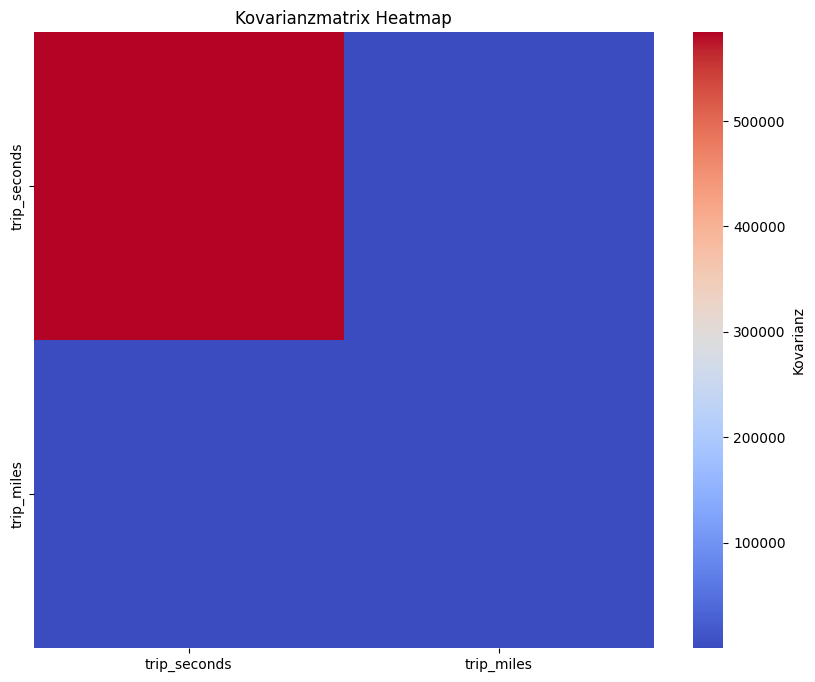

In [235]:
# Berechnung der Kovarianzmatrix
features_for_cov = ['trip_seconds', 'trip_miles']
cov_matrix = Cluster_all_ohe[features_for_cov].cov()

# Erstellen und Anzeigen der Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, cmap='coolwarm', cbar_kws={'label': 'Kovarianz'})
plt.title('Kovarianzmatrix Heatmap')
plt.show()

In [236]:
print(Cluster_all_ohe.columns)

Index(['trip_seconds', 'price_per_mile', 'trip_miles', 'fare', 'temperature',
       'distance_to_chicago', 'distance_from_chicago', 'hour_0', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')


## Data Normalisation/Scaling

In [237]:
columns_to_normalize=["trip_seconds", "trip_miles","price_per_mile", "fare", "temperature","distance_to_chicago", "distance_from_chicago"]
#columns_to_normalize=['connectionDuration', 'chargingDuration', 'kWhDelivered', 'kWhRequested', 'precipitation', 'temperature', 'minutesAvailable']

In [238]:
scaler = MinMaxScaler()
Cluster_all_ohe[columns_to_normalize] = scaler.fit_transform(Cluster_all_ohe[columns_to_normalize])
print(Cluster_all_ohe.columns)

Index(['trip_seconds', 'price_per_mile', 'trip_miles', 'fare', 'temperature',
       'distance_to_chicago', 'distance_from_chicago', 'hour_0', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')


In [239]:
Cluster_all_ohe.describe()

,trip_seconds,price_per_mile,trip_miles,fare,temperature,distance_to_chicago,distance_from_chicago,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
count,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000,95616.000000
mean,0.007887,0.451995,0.047637,0.075408,0.597641,0.087723,0.097413,0.020457,0.017162,0.012226,0.008733,0.004832,0.005700,0.019882,0.043696,0.051696,0.048893,0.048005,0.057229,0.057051,0.056183,0.058107,0.066171,0.074381,0.077738,0.070480,0.055022,0.044156,0.041573,0.035716,0.024912,0.136379,0.153771,0.154828,0.162452,0.174291,0.126485,0.091794,0.080761,0.076567,0.096584,0.090769,0.093164,0.096281,0.080008,0.082350,0.077246,0.084201,0.074946,0.067123
std,0.009592,0.274909,0.038606,0.032827,0.203023,0.142772,0.134051,0.141558,0.129877,0.109894,0.093041,0.069344,0.075282,0.139594,0.204418,0.221414,0.215646,0.213777,0.232281,0.231941,0.230276,0.233948,0.248582,0.262391,0.267760,0.255955,0.228025,0.205442,0.199611,0.185582,0.155858,0.343192,0.360731,0.361742,0.368867,0.379361,0.332397,0.288737,0.272468,0.265904,0.295392,0.287282,0.290664,0.294978,0.271306,0.274899,0.266984,0.277691,0.263305,0.250236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.004945,0.216344,0.025316,0.056440,0.428571,0.025883,0.026002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.006764,0.429509,0.037975,0.069484,0.571429,0.048011,0.063516,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.009236,0.675813,0.057278,0.084703,0.780952,0.078244,0.102592,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0

## PCA

(95616, 50)
the total variancein our dataset is 2.8729095538964122
the 95% of the variance in our dataset is 2.7292640762015914


Text(0, 0.5, '% explained_variance_ratio')

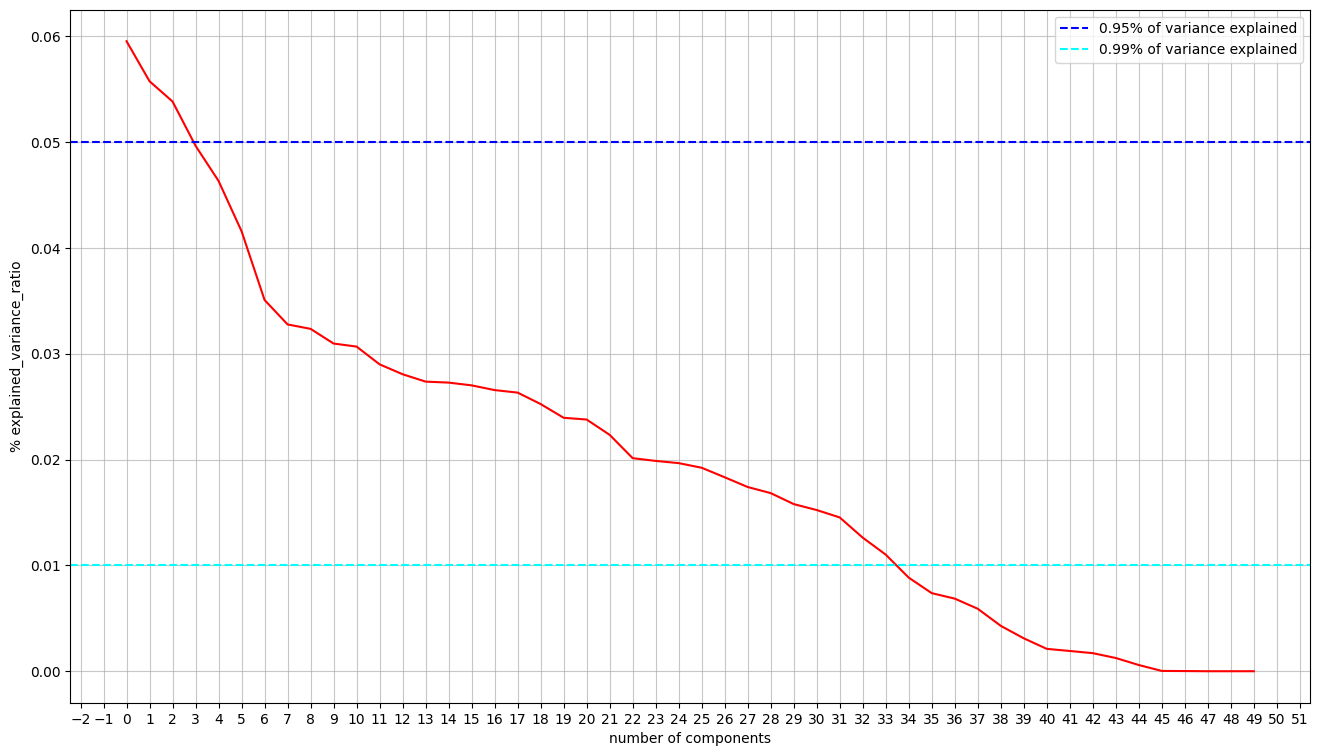

In [240]:
number_comp= Cluster_all_ohe.shape[1]
print(Cluster_all_ohe.shape)
pca= PCA(n_components=number_comp, random_state=47)
X_pca = pca.fit(Cluster_all_ohe).transform(Cluster_all_ohe)

total_variance =sum(pca.explained_variance_)
variance95= total_variance * 0.95
print(f"the total variancein our dataset is {total_variance}")
print(f"the 95% of the variance in our dataset is {variance95}")

a=zip(range(0,number_comp), pca.explained_variance_)
a= pd.DataFrame(a, columns=["PCA Comp", "Explained Variance"])

plt.figure(1, figsize=(16,9))
plt.plot(pca.explained_variance_ratio_, c="r")
tick_step = 1
plt.gca().xaxis.set_major_locator(MultipleLocator(tick_step))
plt.axhline(y=0.05, color='blue', linestyle='--', label='0.95% of variance explained')
plt.axhline(y=0.01, color='cyan', linestyle='--', label='0.99% of variance explained')
plt.grid(True, alpha=0.7)
plt.legend()
plt.xlabel("number of components")
plt.ylabel("% explained_variance_ratio")

## Finding Number of Clusters

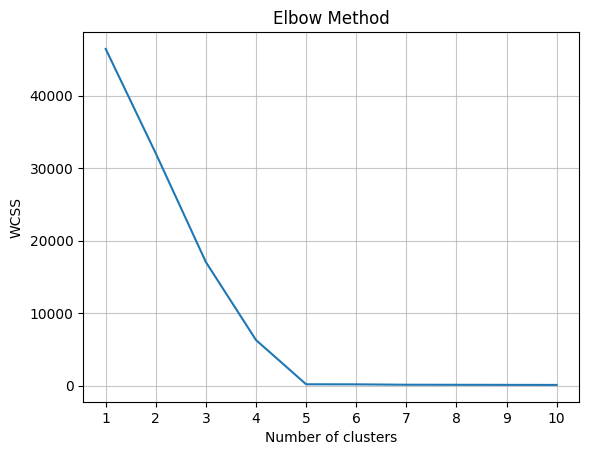

In [241]:
pca= PCA(n_components=3, random_state=47)
X_pca = pca.fit(Cluster_all_ohe).transform(Cluster_all_ohe)

wcss = []  # Within-Cluster-Sum-of-Squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
tick_step = 1
plt.gca().xaxis.set_major_locator(MultipleLocator(tick_step))
plt.grid(True, alpha=0.7)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within-Cluster-Sum-of-Squares
plt.show()

## Clustering (Hard)

In [242]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=47)
kmeans.fit(X_pca)

KMeans(n_clusters=5, random_state=47)

In [243]:
labels = kmeans.labels_

# Calculate the silhouette score for c_raw2
silhouette_score = silhouette_score(X_pca, labels)
#print(f"Silhouette Score for 4 clusters: {silhouette_score}")

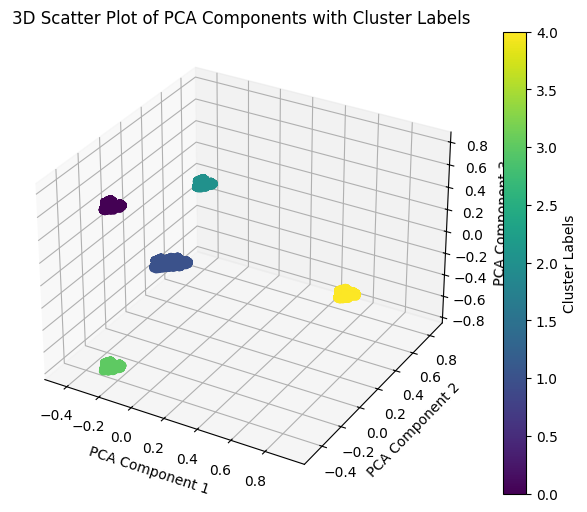

In [244]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color-coded clusters
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='viridis')

# Add labels and title
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D Scatter Plot of PCA Components with Cluster Labels')

# Add colorbar for cluster labels
colorbar = plt.colorbar(scatter)
colorbar.set_label('Cluster Labels')

# Display the plot
plt.show()

In [245]:
Cluster_all_knn = Cluster_all.copy()
Cluster_all_knn["clusters"]= labels

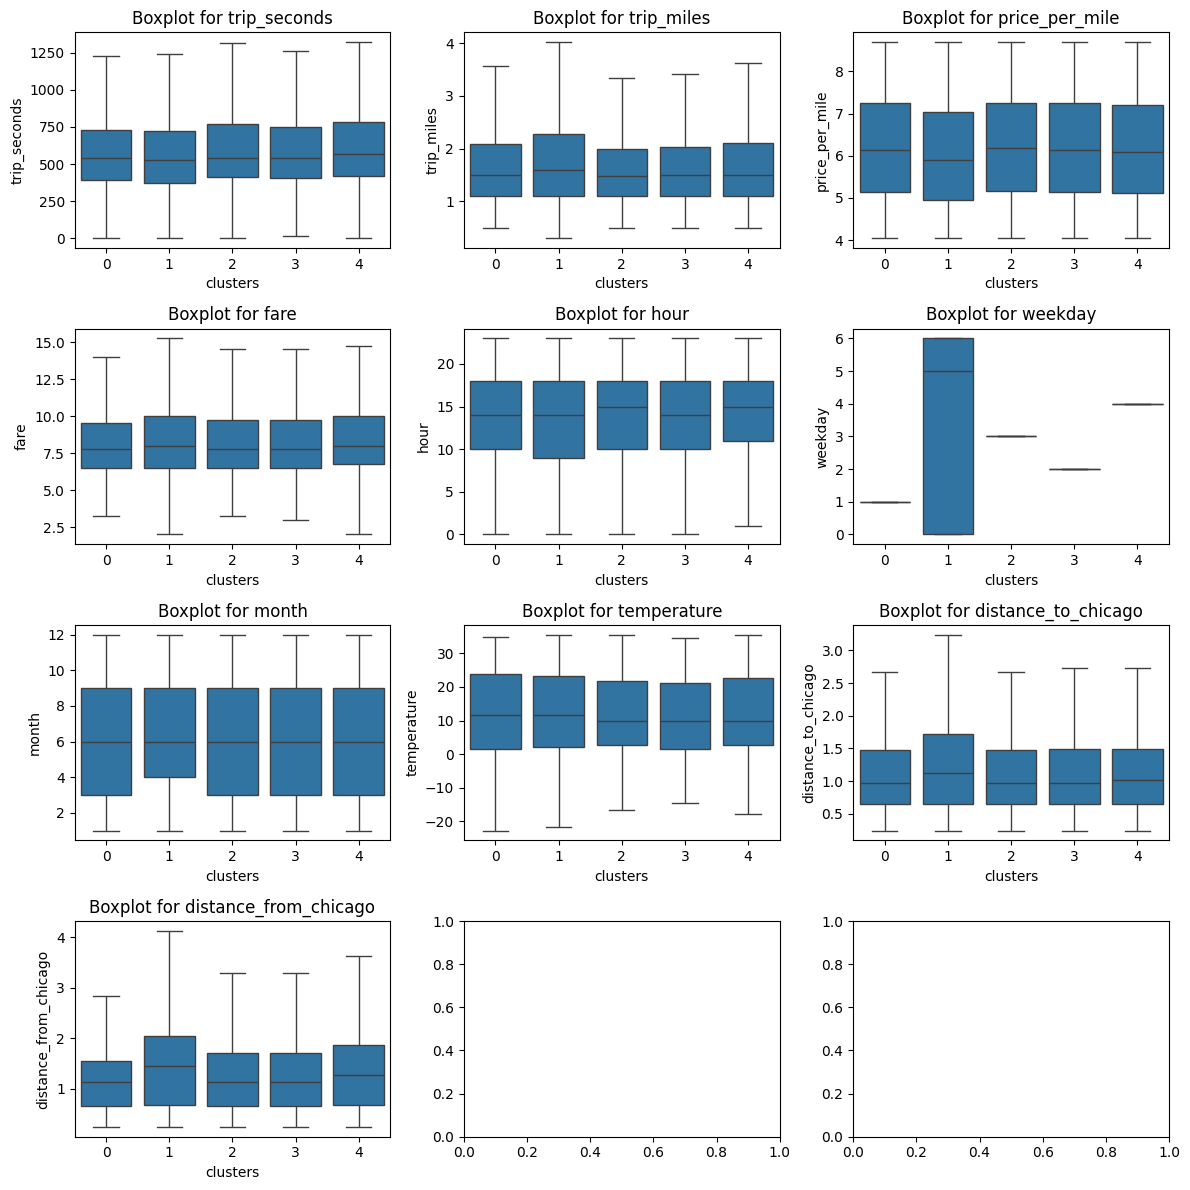

In [246]:
features = ["trip_seconds", "trip_miles", "price_per_mile", "fare", "hour", "weekday", "month","temperature", "distance_to_chicago", "distance_from_chicago"]

# Create a 3x3 subplot grid
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through features and create boxplots
for i, feature in enumerate(features):
    
    sns.boxplot(x='clusters', y=feature, data=Cluster_all_knn, ax=axes[i], showfliers=False)
    
    # Set subplot title
    axes[i].set_title(f'Boxplot for {feature}')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

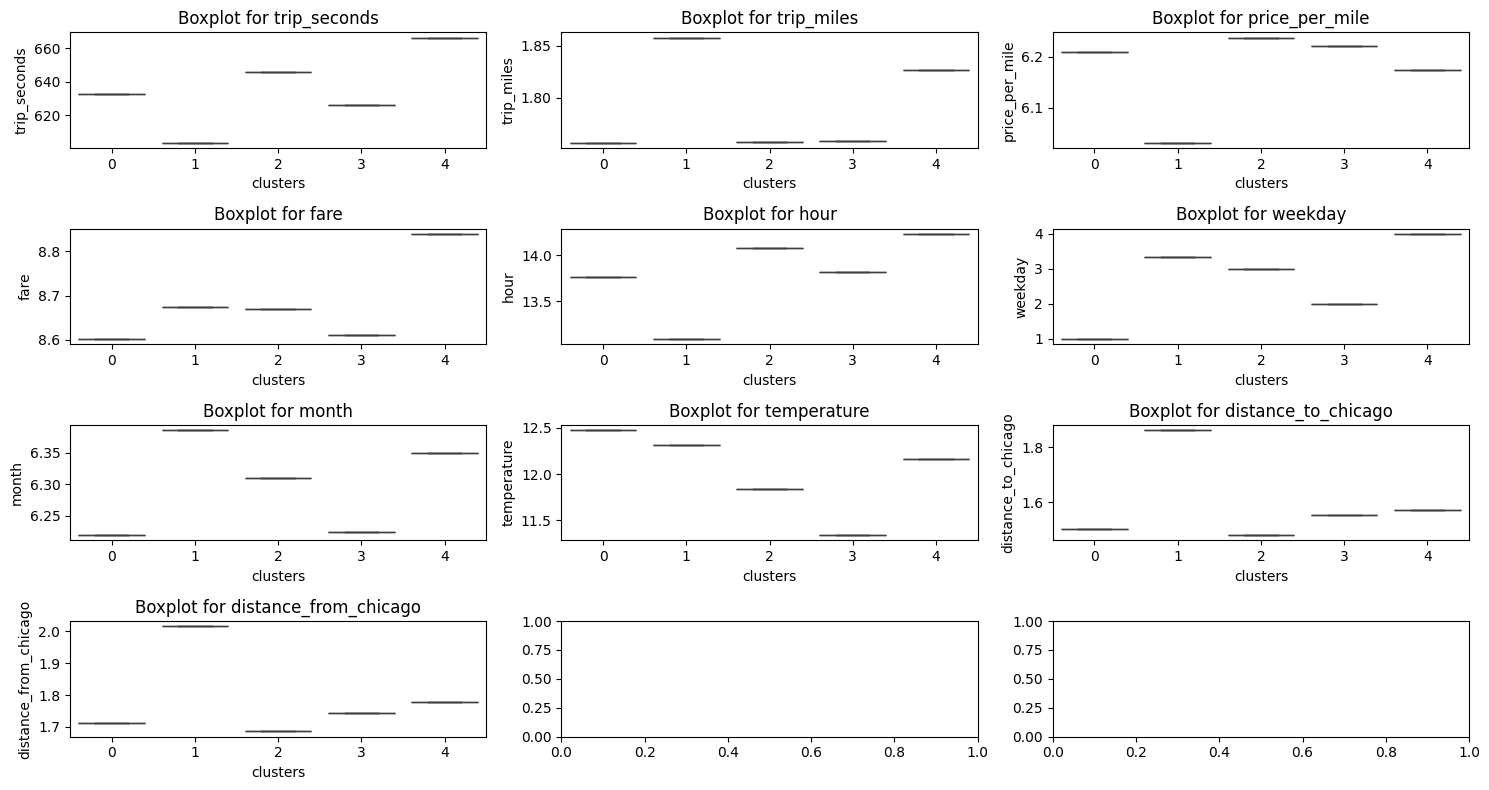

In [247]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through features and create boxplots
for i, feature in enumerate(features):
    df = Cluster_all_knn[[feature, 'clusters']].groupby('clusters', as_index=False).mean()
    
    # Plot boxplot in the i-th subplot
    sns.boxplot(x='clusters', y=df.columns[1], data=df, ax=axes[i])
    
    # Set subplot title
    axes[i].set_title(f'Boxplot for {df.columns[1]}')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [248]:
Cluster_all_knn[columns_to_normalize] = scaler.fit_transform(Cluster_all_knn[columns_to_normalize])

<Figure size 1600x900 with 0 Axes>

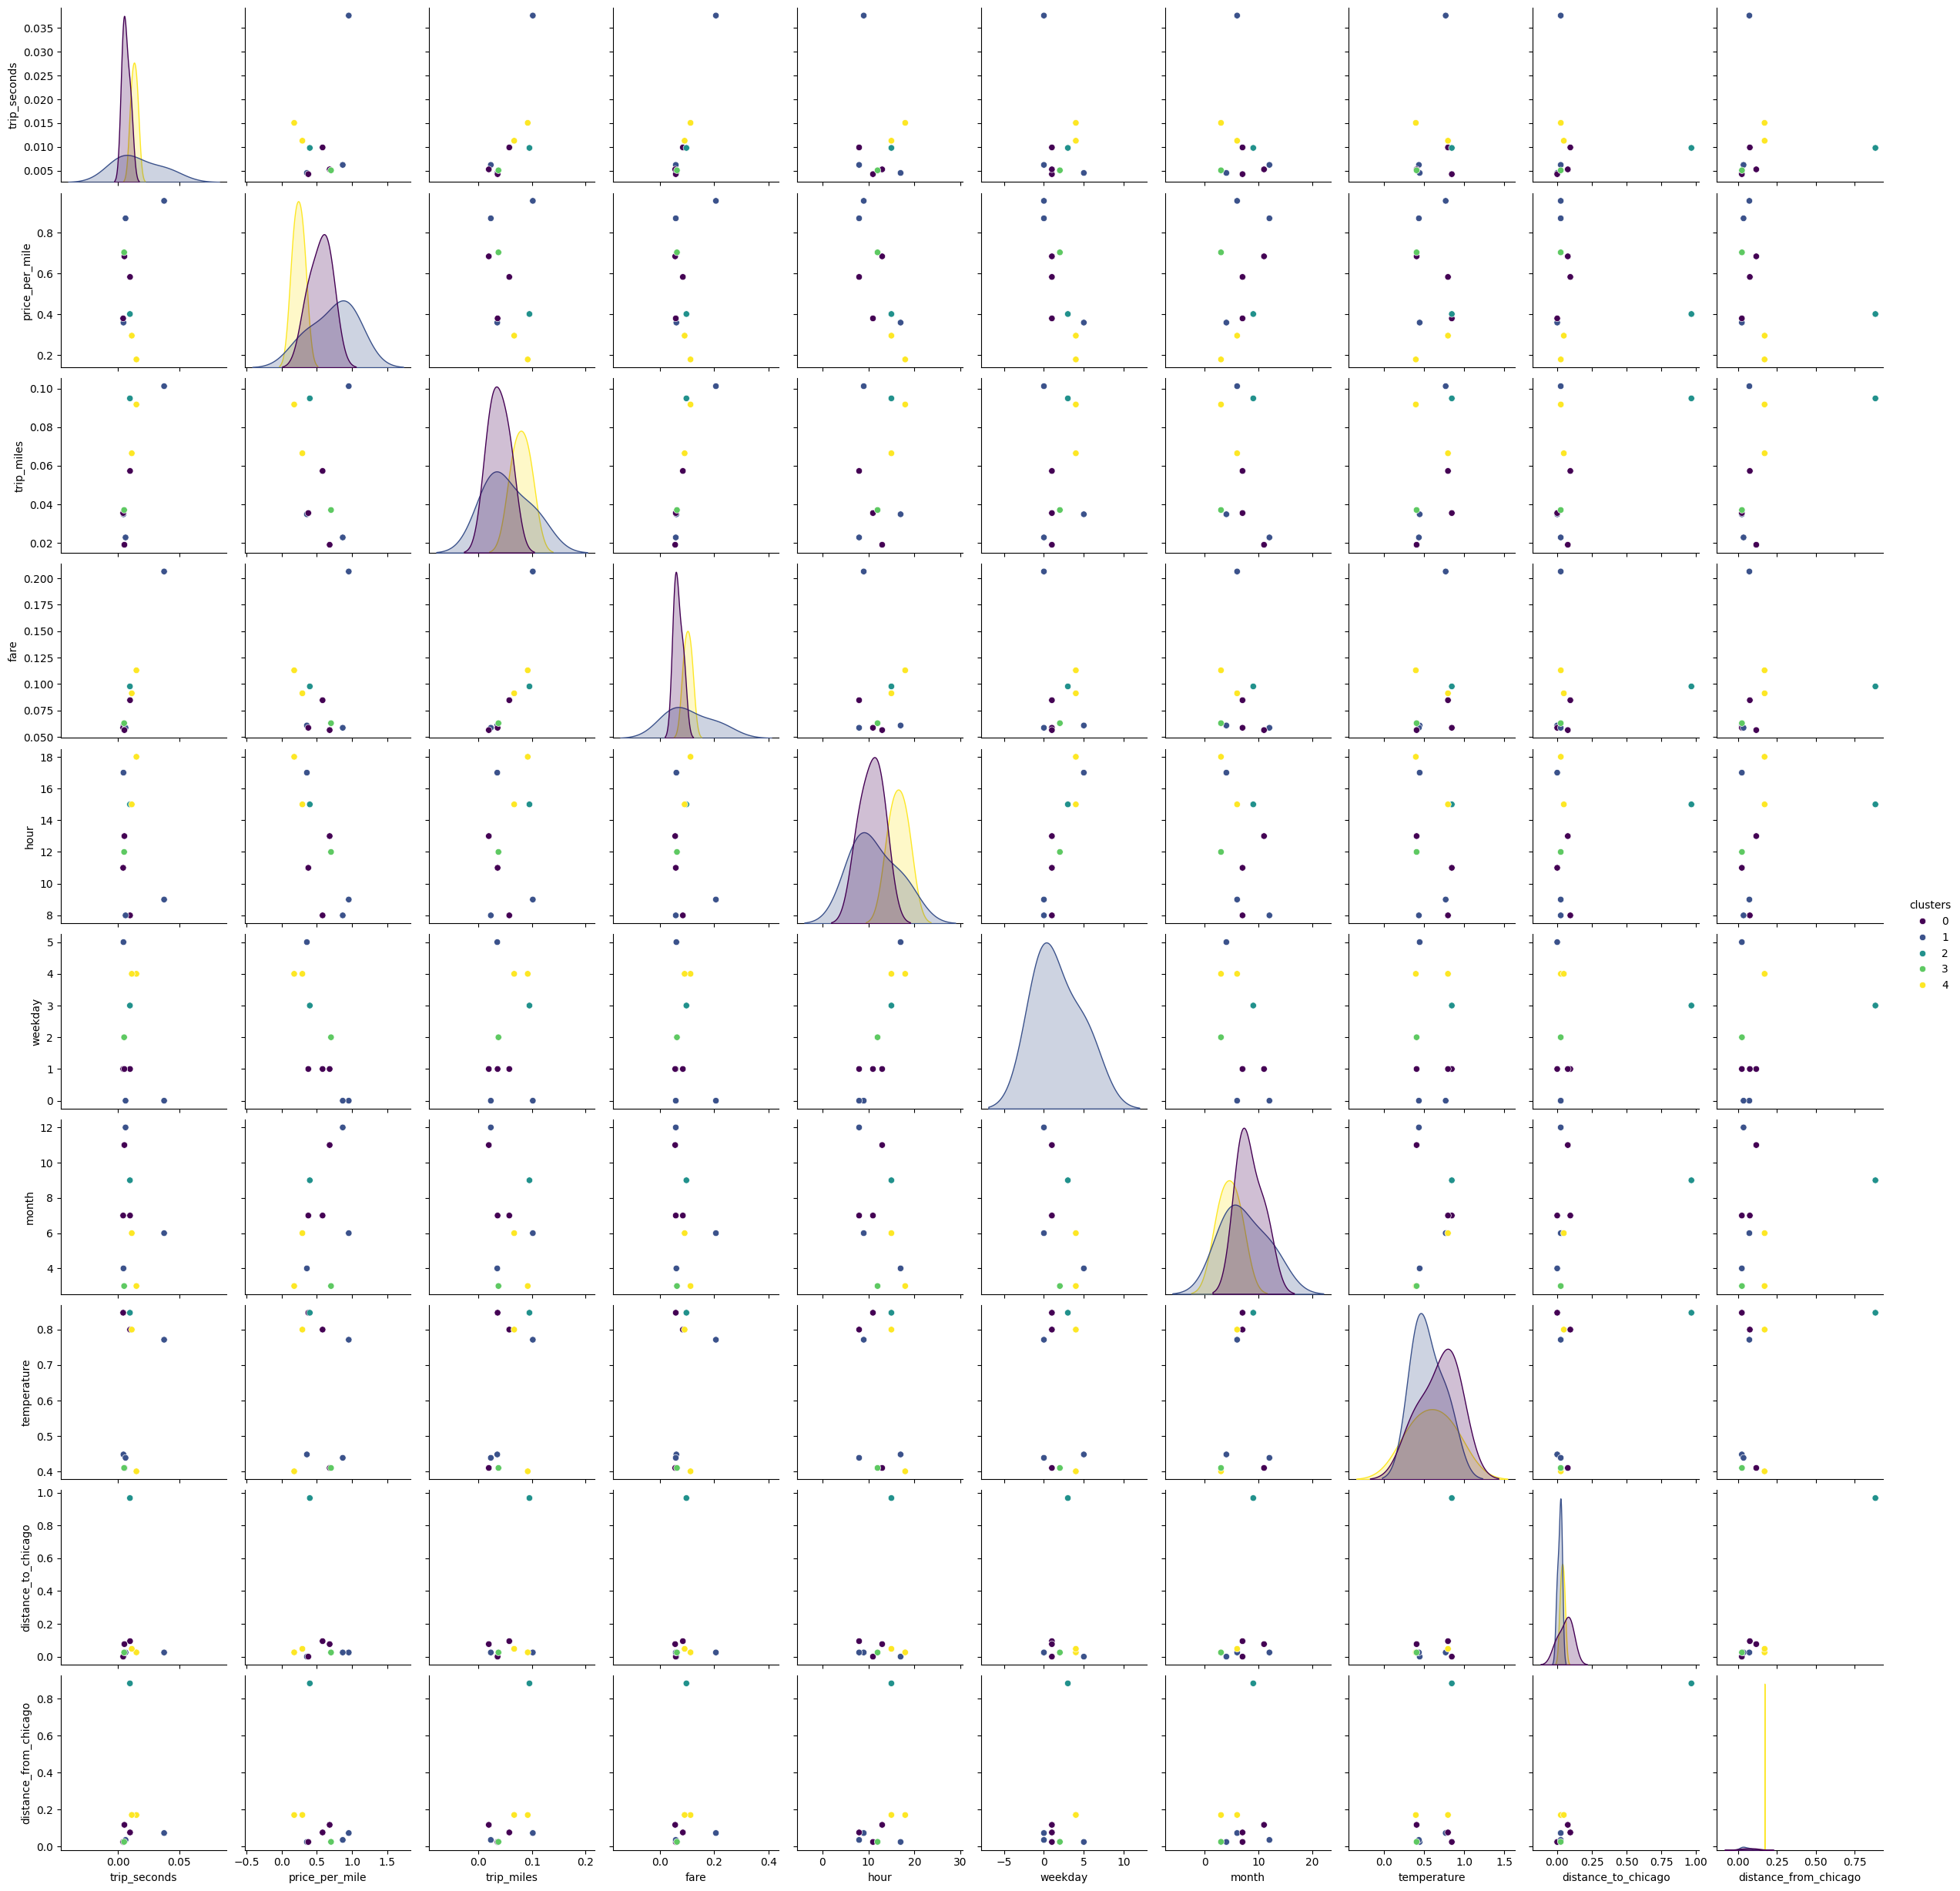

In [249]:
plt.figure(figsize=(16,9))
numerical_columns = Cluster_all_knn.columns[Cluster_all_knn.columns != "clusters"]
pairplot = sns.pairplot(Cluster_all_knn.sample(n=10, random_state=42), hue="clusters", vars=numerical_columns, palette="viridis")

pairplot.savefig("pairplot_knn.png")

plt.show()

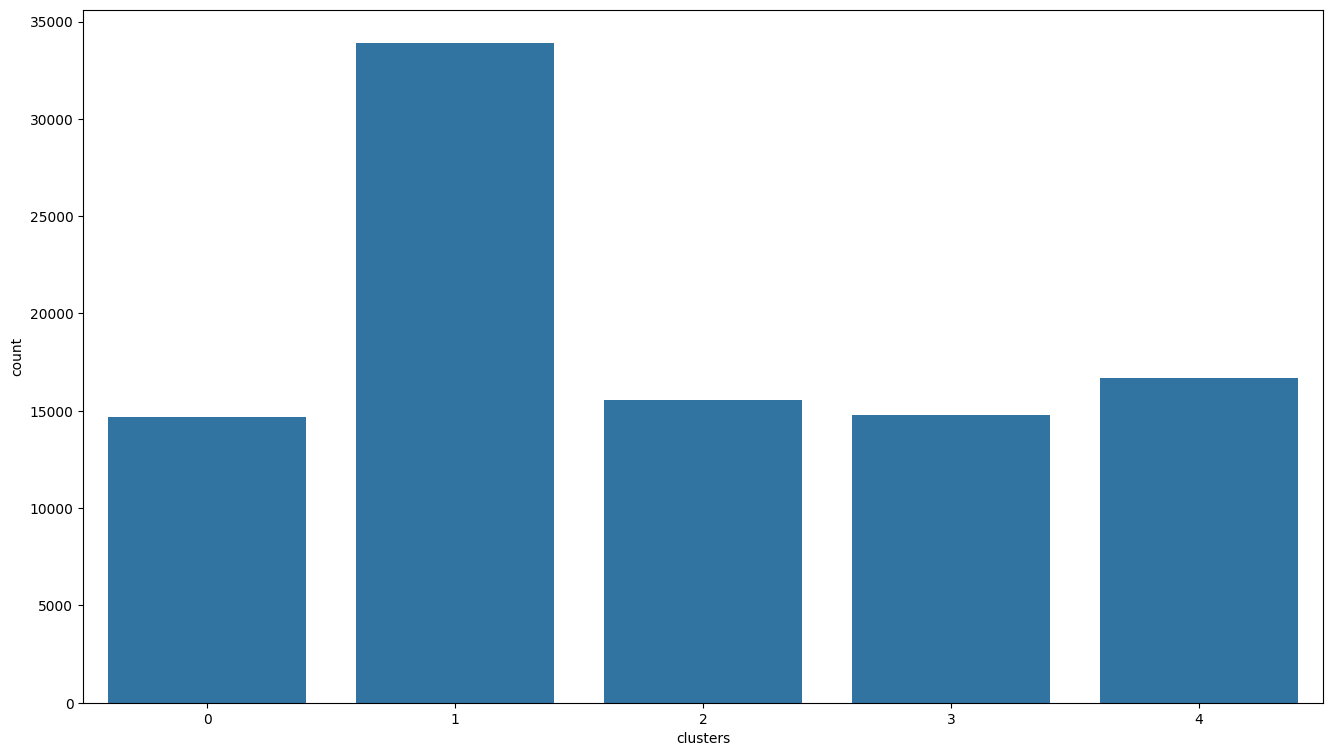

In [250]:
plt.figure(figsize=(16,9))
sns.countplot(data=Cluster_all_knn, x="clusters")
plt.show()

## Clustering (Soft)

In [251]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=5).fit(X_pca)
labels = gmm.predict(X_pca)

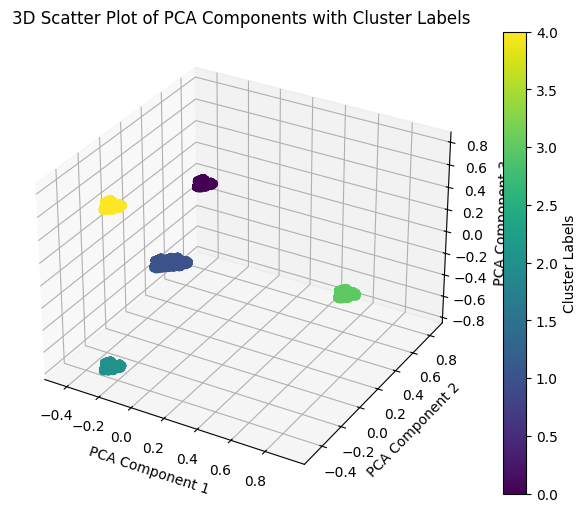

In [252]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color-coded clusters
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='viridis')

# Add labels and title
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D Scatter Plot of PCA Components with Cluster Labels')

# Add colorbar for cluster labels
colorbar = plt.colorbar(scatter)
colorbar.set_label('Cluster Labels')

# Display the plot
plt.show()

In [253]:
probs = gmm.predict_proba(X_pca)
print(probs[:5].round(3))
#print(X_pca)

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [254]:
Cluster_all_gmm = Cluster_all.copy()
Cluster_all_gmm["clusters"]= labels

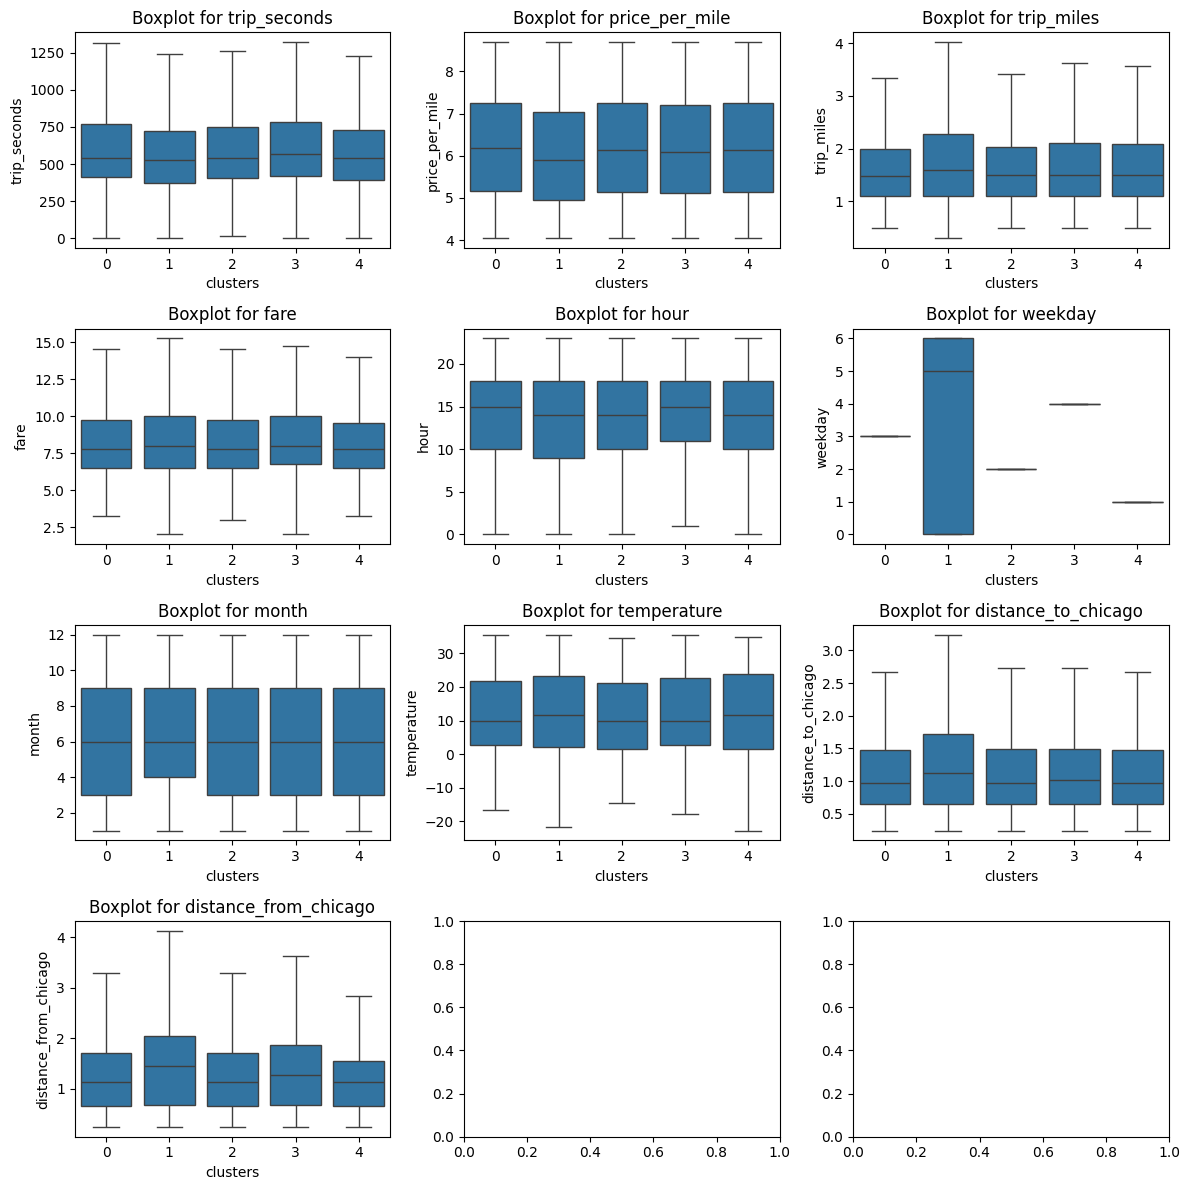

In [255]:
features = ["trip_seconds", "price_per_mile", "trip_miles", "fare", "hour", "weekday", "month","temperature", "distance_to_chicago", "distance_from_chicago"]

# Create a 3x3 subplot grid
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through features and create boxplots
for i, feature in enumerate(features):
    
    sns.boxplot(x='clusters', y=feature, data=Cluster_all_gmm, ax=axes[i], showfliers=False)
    
    # Set subplot title
    axes[i].set_title(f'Boxplot for {feature}')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

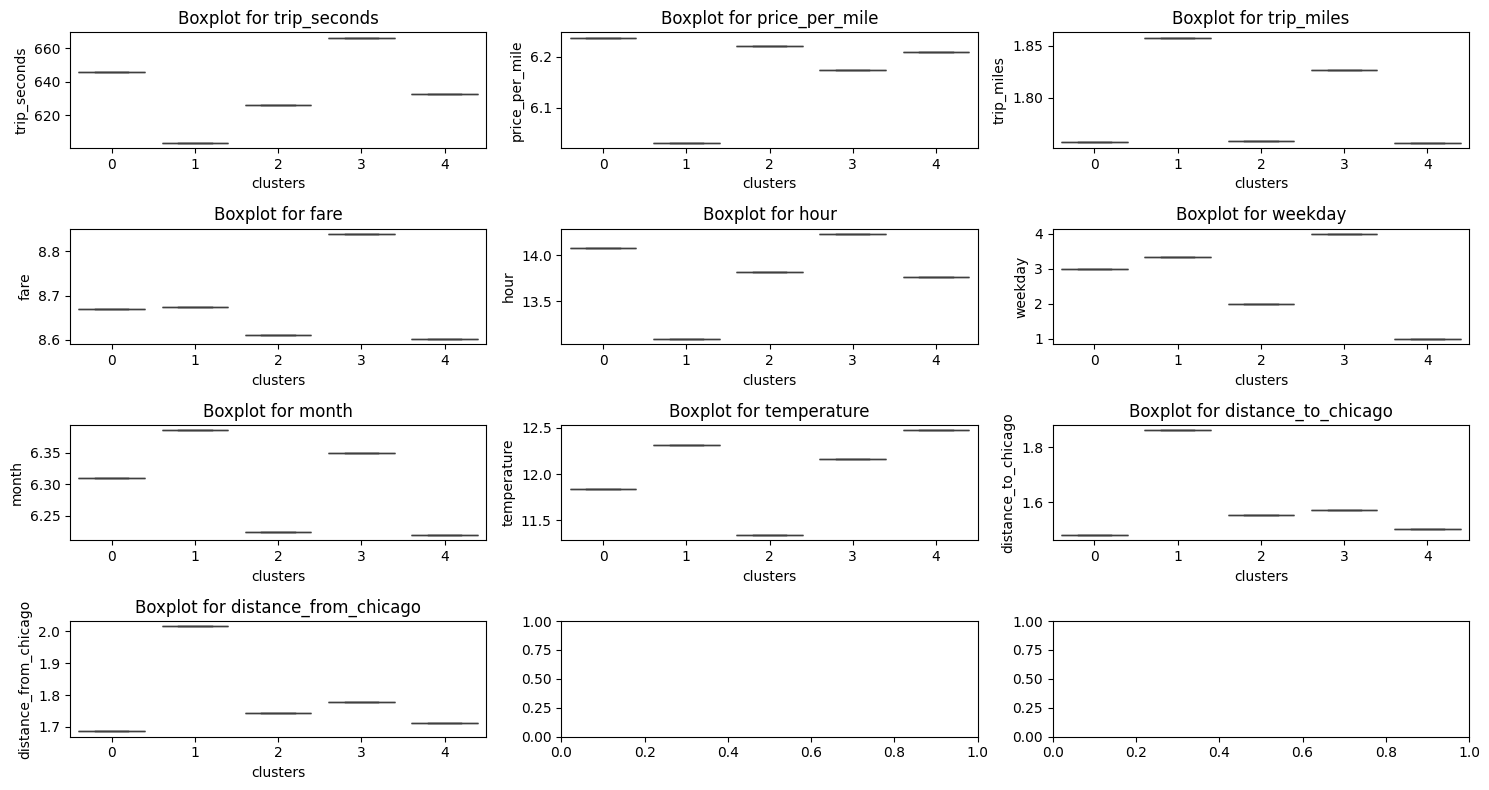

In [256]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through features and create boxplots
for i, feature in enumerate(features):
    df = Cluster_all_gmm[[feature, 'clusters']].groupby('clusters', as_index=False).mean()
    
    # Plot boxplot in the i-th subplot
    sns.boxplot(x='clusters', y=df.columns[1], data=df, ax=axes[i])
    
    # Set subplot title
    axes[i].set_title(f'Boxplot for {df.columns[1]}')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [257]:
Cluster_all_gmm[columns_to_normalize] = scaler.fit_transform(Cluster_all_gmm[columns_to_normalize])

In [258]:
plt.figure(figsize=(16,9))
numerical_columns = Cluster_all_gmm.columns[Cluster_all_gmm.columns != "clusters"]
pairplot = sns.pairplot(Cluster_all_gmm.sample(n=10, random_state=42), hue="clusters", vars=numerical_columns, palette="viridis")

pairplot.savefig("pairplot_gmm.png")

plt.show()

<Figure size 1600x900 with 0 Axes>

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(16,9))
sns.countplot(data=Cluster_all_gmm, x="clusters")
plt.show()

## Spatial Kernel Density Estimation

## Comparison